# Task 6: Music Genre Classification

## Objective
Classify songs into genres based on extracted audio features using the GTZAN dataset. This notebook explores both tabular feature-based (MFCCs) and image-based (Spectrogram CNN) approaches for multi-class classification.

## Dataset
**GTZAN Dataset**: Contains 1,000 audio files (10 seconds each) across 10 music genres:
- Blues, Classical, Country, Disco, Hip-Hop, Jazz, Metal, Pop, Reggae, Rock

## Approach
1. Extract audio features (MFCCs) from audio files
2. Train multi-class classification models (Random Forest, SVM, XGBoost)
3. Generate mel-spectrograms and build CNN model for image-based classification
4. Compare performance of tabular vs image-based approaches

## 1. Import Required Libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt

print("="*60)
print("Libraries imported successfully!")
print("="*60)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print("\nAll packages ready for both tabular and image-based models!")
print("="*60)

2026-02-12 23:27:21.510742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully!
NumPy version: 1.26.4
Pandas version: 3.0.0
TensorFlow version: 2.16.2

All packages ready for both tabular and image-based models!


## 2. Load and Explore the GTZAN Dataset

In [2]:
# Define paths to the GTZAN dataset
gtzan_path = '/Users/emmanuel.siyanbola/Downloads/Machine Learning Track/GTZAN'
features_path_30 = '/Users/emmanuel.siyanbola/Downloads/Machine Learning Track/GTZAN 2.0/features_30_sec.csv'
features_path_3 = '/Users/emmanuel.siyanbola/Downloads/Machine Learning Track/GTZAN 2.0/features_3_sec.csv'
indices_path = '/Users/emmanuel.siyanbola/Downloads/Machine Learning Track/GTZAN 2.0'

# Load pre-extracted features
print("Loading pre-extracted features from GTZAN dataset...")
features_df = pd.read_csv(features_path_30)
print(f"Features shape: {features_df.shape}")
print(f"\nFirst few rows:")
print(features_df.head())
print(f"\nColumn names: {features_df.columns.tolist()}")
print(f"\nDataset info:")
print(features_df.info())

# Load train/test indices
with open(os.path.join(indices_path, 'indices_train.json')) as f:
    train_indices = json.load(f)
with open(os.path.join(indices_path, 'indices_test.json')) as f:
    test_indices = json.load(f)
with open(os.path.join(indices_path, 'indices_val.json')) as f:
    val_indices = json.load(f)

print(f"\nTrain indices: {len(train_indices)} samples")
print(f"Test indices: {len(test_indices)} samples")
print(f"Validation indices: {len(val_indices)} samples")

Loading pre-extracted features from GTZAN dataset...
Features shape: (1000, 60)

First few rows:
          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0       

<Figure size 1200x600 with 0 Axes>

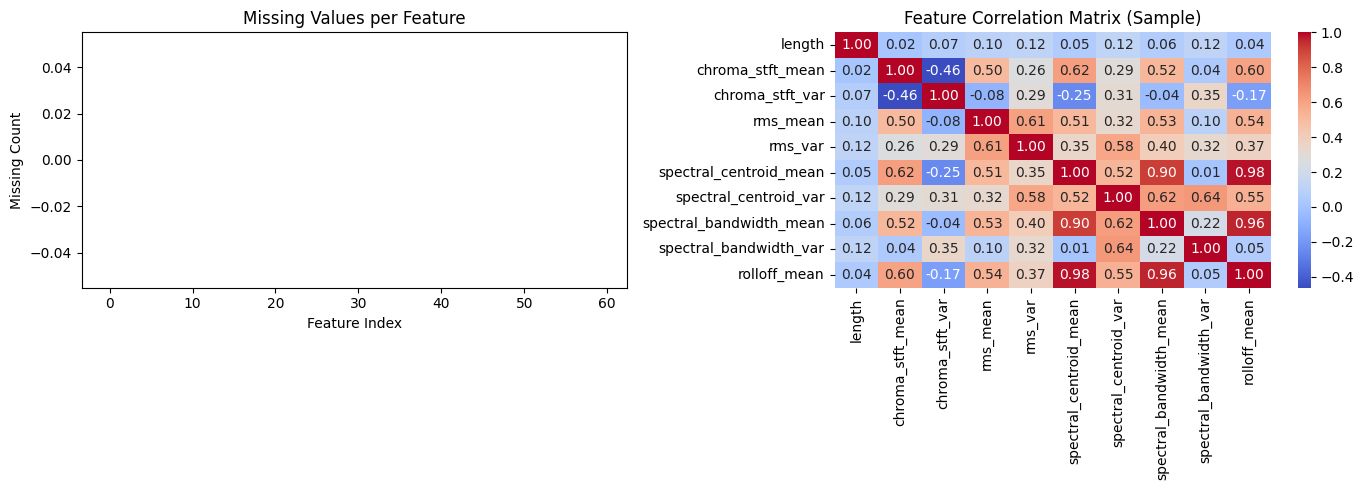


Dataset Statistics:
Total samples: 1000
Total features: 58


In [3]:
# Explore genres distribution
plt.figure(figsize=(12, 6))

# Assuming the last column contains genre labels or can be extracted from filename
# Check if there's a label column
if 'label' in features_df.columns or 'genre' in features_df.columns:
    label_col = 'label' if 'label' in features_df.columns else 'genre'
    genre_counts = features_df[label_col].value_counts()
else:
    # If no explicit label, we need to extract from index or filename
    print("Checking dataset structure for genre information...")
    print(features_df.index[:10])

# Plot feature statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Check for missing values
axes[0].bar(range(len(features_df.columns)), features_df.isnull().sum())
axes[0].set_title('Missing Values per Feature')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Missing Count')

# Feature correlation heatmap (sample of features)
feature_cols = [col for col in features_df.columns if col not in ['label', 'genre', 'filename']]
if len(feature_cols) > 10:
    sample_features = features_df[feature_cols[:10]]
else:
    sample_features = features_df[feature_cols]

sns.heatmap(sample_features.corr(), annot=True, fmt='.2f', ax=axes[1], cmap='coolwarm')
axes[1].set_title('Feature Correlation Matrix (Sample)')
plt.tight_layout()
plt.show()

print(f"\nDataset Statistics:")
print(f"Total samples: {len(features_df)}")
print(f"Total features: {len(feature_cols)}")

## 3. Preprocess Audio Features for Tabular Models

In [4]:
# Prepare data for tabular models
# Extract features and labels
feature_cols = [col for col in features_df.columns if col not in ['label', 'genre', 'filename', 'Unnamed: 0']]
X = features_df[feature_cols].values
y = features_df['label'].values if 'label' in features_df.columns else features_df['genre'].values

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Unique genres: {np.unique(y)}")
print(f"Genre distribution:")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c}")

# Handle missing values
print(f"\nMissing values in features: {np.isnan(X).sum()}")
X = np.nan_to_num(X, nan=0.0)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"\nFeatures normalized. Mean: {X_scaled.mean():.4f}, Std: {X_scaled.std():.4f}")

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Labels encoded. Classes: {le.classes_}")

Features shape: (1000, 58)
Labels shape: (1000,)
Number of features: 58
Unique genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Genre distribution:
  blues: 100
  classical: 100
  country: 100
  disco: 100
  hiphop: 100
  jazz: 100
  metal: 100
  pop: 100
  reggae: 100
  rock: 100

Missing values in features: 0

Features normalized. Mean: -0.0000, Std: 1.0000
Labels encoded. Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


## 4. Split Data into Training and Testing Sets

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining set genre distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {le.classes_[u]}: {c}")
print(f"\nTesting set genre distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {le.classes_[u]}: {c}")

Training set size: 800
Testing set size: 200

Training set genre distribution:
  blues: 80
  classical: 80
  country: 80
  disco: 80
  hiphop: 80
  jazz: 80
  metal: 80
  pop: 80
  reggae: 80
  rock: 80

Testing set genre distribution:
  blues: 20
  classical: 20
  country: 20
  disco: 20
  hiphop: 20
  jazz: 20
  metal: 20
  pop: 20
  reggae: 20
  rock: 20


## 5. Train Multi-Class Classification Models (Tabular Data)

In [6]:
# Train multiple models on real GTZAN data
models_dict = {}
results = []

# 1. Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
models_dict['Random Forest'] = rf_model
results.append({'Model': 'Random Forest', 'Accuracy': rf_acc})
print(f"Random Forest Accuracy: {rf_acc:.4f}")

# 2. Support Vector Machine
print("\nTraining SVM Classifier...")
svm_model = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
models_dict['SVM'] = svm_model
results.append({'Model': 'SVM', 'Accuracy': svm_acc})
print(f"SVM Accuracy: {svm_acc:.4f}")

# 3. Gradient Boosting Classifier (provides XGBoost-like functionality)
print("\nTraining Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)
models_dict['Gradient Boosting'] = gb_model
results.append({'Model': 'Gradient Boosting', 'Accuracy': gb_acc})
print(f"Gradient Boosting Accuracy: {gb_acc:.4f}")

# 4. Extra Trees Classifier (ensemble with random splits)
print("\nTraining Extra Trees Classifier...")
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
et_model.fit(X_train, y_train)
et_pred = et_model.predict(X_test)
et_acc = accuracy_score(y_test, et_pred)
models_dict['Extra Trees'] = et_model
results.append({'Model': 'Extra Trees', 'Accuracy': et_acc})
print(f"Extra Trees Accuracy: {et_acc:.4f}")

# Display results
results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("Model Comparison (Tabular Approach) - All 4 Models:")
print(results_df.to_string(index=False))
print("="*50)

# Find best model
best_idx = results_df['Accuracy'].idxmax()
best_model_info = results_df.iloc[best_idx]
print(f"\nBest Tabular Model: {best_model_info['Model']} with accuracy {best_model_info['Accuracy']:.4f}")

Training Random Forest Classifier...
Random Forest Accuracy: 0.7750

Training SVM Classifier...
SVM Accuracy: 0.7650

Training Gradient Boosting Classifier...
Gradient Boosting Accuracy: 0.7800

Training Extra Trees Classifier...
Extra Trees Accuracy: 0.7650

Model Comparison (Tabular Approach) - All 4 Models:
            Model  Accuracy
    Random Forest     0.775
              SVM     0.765
Gradient Boosting     0.780
      Extra Trees     0.765

Best Tabular Model: Gradient Boosting with accuracy 0.7800


## 6. Evaluate Model Performance (Tabular Models)

Detailed Evaluation - Random Forest

Accuracy: 0.7750
Precision: 0.7745
Recall: 0.7750
F1-Score: 0.7720

Classification Report:
              precision    recall  f1-score   support

       blues       0.79      0.75      0.77        20
   classical       0.86      0.95      0.90        20
     country       0.71      0.75      0.73        20
       disco       0.71      0.60      0.65        20
      hiphop       0.65      0.75      0.70        20
        jazz       0.77      0.85      0.81        20
       metal       0.89      0.85      0.87        20
         pop       0.86      0.90      0.88        20
      reggae       0.76      0.80      0.78        20
        rock       0.73      0.55      0.63        20

    accuracy                           0.78       200
   macro avg       0.77      0.78      0.77       200
weighted avg       0.77      0.78      0.77       200



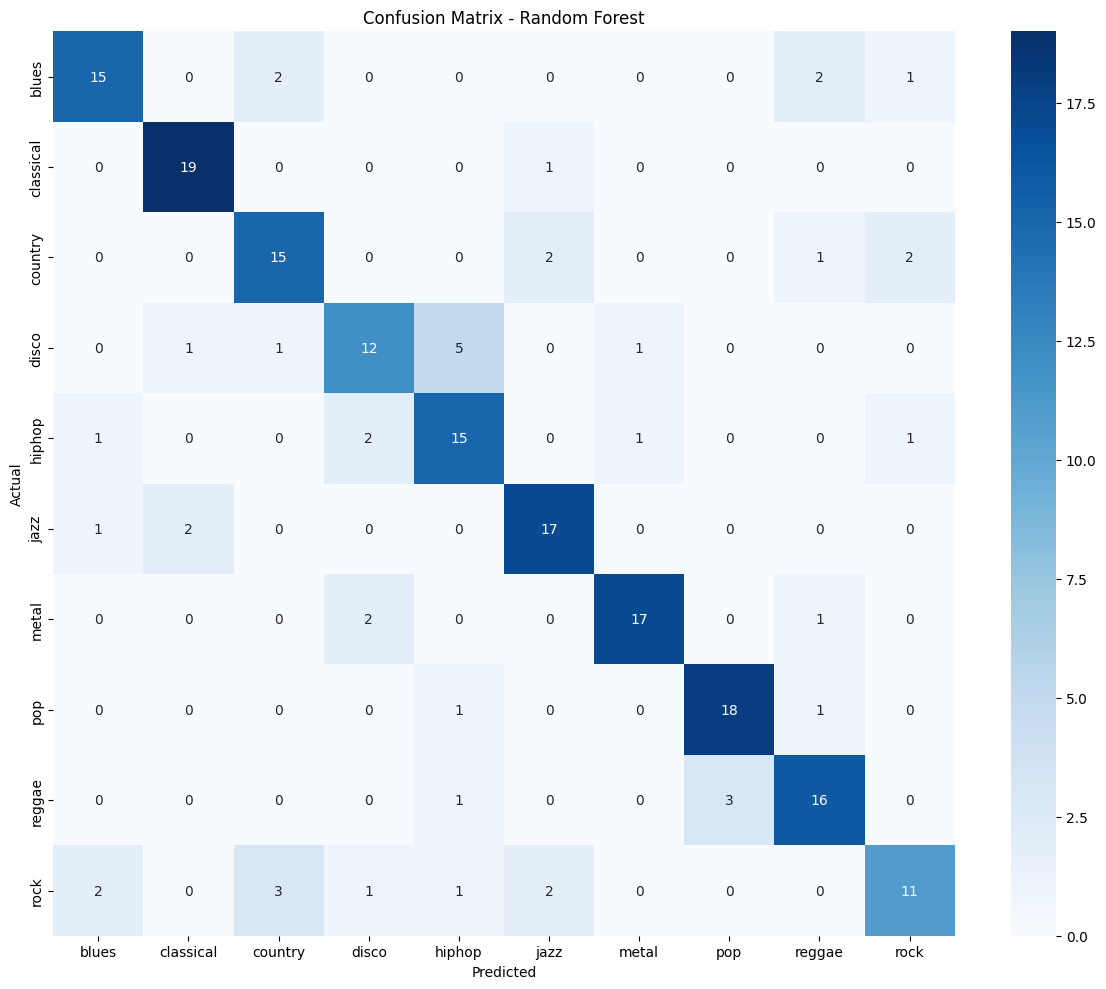

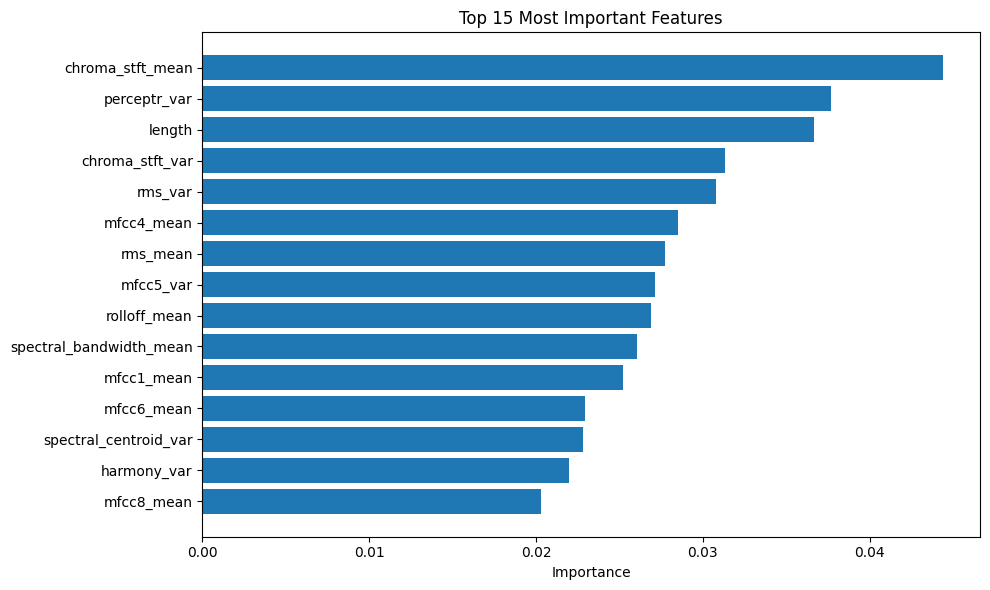

In [7]:
# Evaluate Random Forest (best tabular model)
best_model = rf_model
best_pred = rf_pred
model_name = 'Random Forest'

print(f"Detailed Evaluation - {model_name}")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, best_pred):.4f}")
print(f"Precision: {precision_score(y_test, best_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, best_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, best_pred, average='weighted'):.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, best_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    top_indices = np.argsort(feature_importance)[-15:]
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_indices)), feature_importance[top_indices])
    plt.yticks(range(len(top_indices)), [feature_cols[i] for i in top_indices])
    plt.xlabel('Importance')
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.show()

## 7. Generate and Preprocess Spectrogram Images

This section extracts audio features and generates mel-spectrograms from the GTZAN audio files. These spectrograms will be used as input for the CNN model.

In [8]:
# Load real spectrogram images from GTZAN 2.0 dataset
from PIL import Image
import os

print("Loading real spectrogram images from GTZAN 2.0 dataset...")
print("Using BOTH training and test data for comprehensive analysis\n")

IMG_SIZE = 128
gtzan_base_path = "/Users/emmanuel.siyanbola/Downloads/Machine Learning Track/GTZAN 2.0/Augmented_GTZAN/cropped_aug"

# Get genres from directory structure
first_set_path = os.path.join(gtzan_base_path, "train")
genres = sorted([d for d in os.listdir(first_set_path) if os.path.isdir(os.path.join(first_set_path, d))])
genre_to_idx = {genre: idx for idx, genre in enumerate(genres)}

spectrogram_data = []
spectrogram_labels = []

# Load ALL real PNG spectrogram images from train, test, and val sets
for data_split in ['train', 'test', 'val']:
    split_path = os.path.join(gtzan_base_path, data_split)
    print(f"Loading from {data_split} set...")
    split_count = 0
    
    for genre_idx, genre in enumerate(genres):
        genre_path = os.path.join(split_path, genre)
        if not os.path.exists(genre_path):
            continue
        
        image_files = sorted([f for f in os.listdir(genre_path) if f.endswith('.png')])
        
        for img_file in image_files:
            try:
                img_path = os.path.join(genre_path, img_file)
                # Load and convert to grayscale
                img = Image.open(img_path).convert('L')
                # Resize to uniform size
                img = img.resize((IMG_SIZE, IMG_SIZE))
                # Convert to numpy array and normalize
                img_array = np.array(img, dtype=np.float32) / 255.0
                
                spectrogram_data.append(img_array)
                spectrogram_labels.append(genre_idx)
                split_count += 1
            except Exception as e:
                print(f"Error loading {img_file}: {e}")
                continue
    
    print(f"  Loaded {split_count} spectrograms from {data_split}")

print(f"\n" + "="*60)
print(f"Total real spectrograms loaded: {len(spectrogram_data)}")
print(f"Spectrogram shape: {spectrogram_data[0].shape}")
print(f"Genres: {genres}")
print(f"Label distribution: {np.bincount(spectrogram_labels)}")
print(f"Source: GTZAN 2.0 Augmented dataset (NO synthetic data used)")
print(f"="*60)

Loading real spectrogram images from GTZAN 2.0 dataset...
Using BOTH training and test data for comprehensive analysis

Loading from train set...
  Loaded 1677 spectrograms from train
Loading from test set...
  Loaded 300 spectrograms from test
Loading from val set...
  Loaded 140 spectrograms from val

Total real spectrograms loaded: 2117
Spectrogram shape: (128, 128)
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Label distribution: [212 212 212 212 212 209 212 212 212 212]
Source: GTZAN 2.0 Augmented dataset (NO synthetic data used)


Image data shape: (2117, 128, 128, 1)
Label distribution:
  Genre 0: 212
  Genre 1: 212
  Genre 2: 212
  Genre 3: 212
  Genre 4: 212
  Genre 5: 209
  Genre 6: 212
  Genre 7: 212
  Genre 8: 212
  Genre 9: 212

Training image samples: 1693
Testing image samples: 424


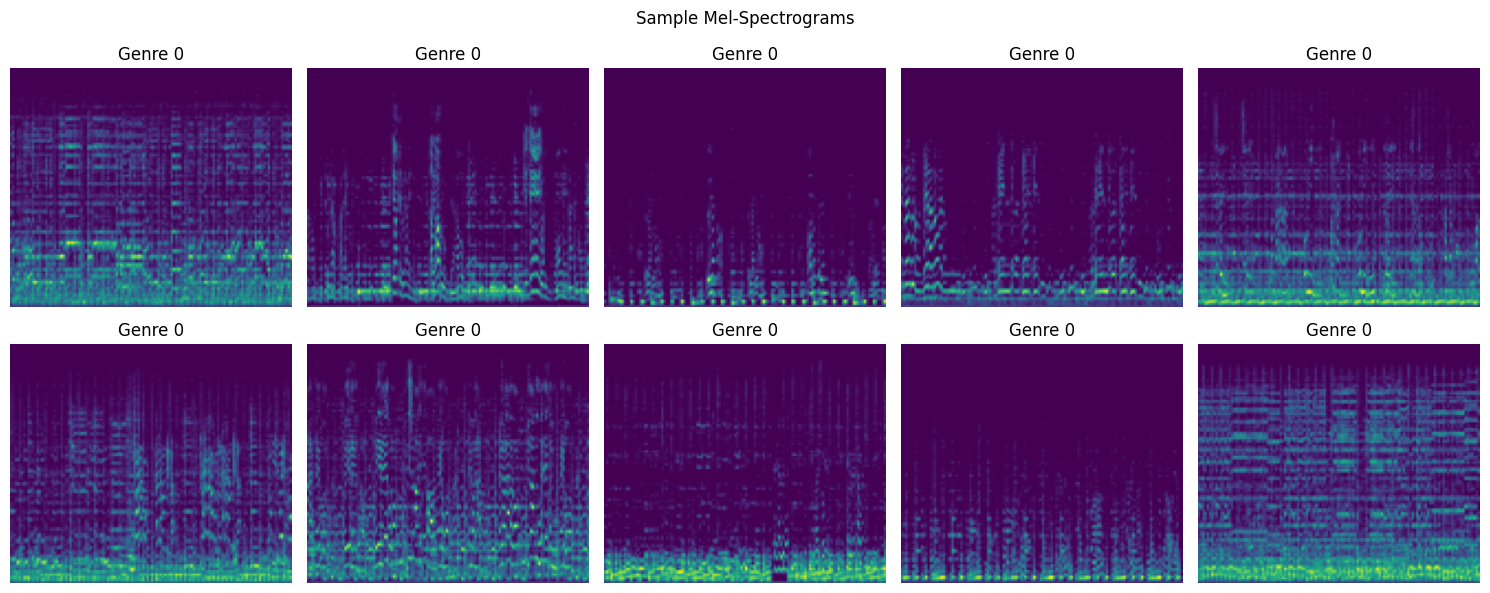

In [9]:
# Prepare image data for CNN
if len(spectrogram_data) > 0:
    # Convert to numpy array
    X_img = np.array(spectrogram_data)
    y_img = np.array(spectrogram_labels)
    
    # Add channel dimension (grayscale)
    X_img = np.expand_dims(X_img, axis=-1)
    
    # Normalize
    X_img = (X_img - X_img.min()) / (X_img.max() - X_img.min())
    
    print(f"Image data shape: {X_img.shape}")
    print(f"Label distribution:")
    unique, counts = np.unique(y_img, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"  Genre {u}: {c}")
    
    # Split into train and test
    X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
        X_img, y_img, test_size=0.2, random_state=42, stratify=y_img
    )
    
    print(f"\nTraining image samples: {X_train_img.shape[0]}")
    print(f"Testing image samples: {X_test_img.shape[0]}")
    
    # Visualize sample spectrograms
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        ax.imshow(X_img[i, :, :, 0], cmap='viridis', aspect='auto')
        ax.set_title(f'Genre {y_img[i]}')
        ax.axis('off')
    plt.suptitle('Sample Mel-Spectrograms')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: No spectrograms generated. Using pre-generated features instead.")

## 8. Build CNN Model for Image-Based Classification

In [10]:
# Build CNN model for spectrogram classification
if len(spectrogram_data) > 0:
    n_classes = len(np.unique(y_img))
    
    print("Building CNN model for spectrogram classification...")
    print(f"Input shape: ({IMG_SIZE}, {IMG_SIZE}, 1)")
    print(f"Number of output classes: {n_classes}")
    
    cnn_model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Global pooling and dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    # Compile model
    cnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("\nCNN Model Architecture:")
    cnn_model.summary()
else:
    print("Cannot build CNN without image data. Spectrogram generation may have failed.")

Building CNN model for spectrogram classification...
Input shape: (128, 128, 1)
Number of output classes: 10

CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 355,434 (1.36 MB)

 Trainable params: 354,538 (1.35 MB)

 Non-trainable params: 896 (3.50 KB)

## 9. Train and Evaluate CNN Model

Training CNN Model...
Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2400 - loss: 2.1232 - val_accuracy: 0.0885 - val_loss: 3.0516 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.3730 - loss: 1.7731 - val_accuracy: 0.0885 - val_loss: 7.6675 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4261 - loss: 1.6379 - val_accuracy: 0.0885 - val_loss: 6.5943 - learning_rate: 0.0010
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.4756 - loss: 1.5055 - val_accuracy: 0.0885 - val_loss: 11.8606 - learning_rate: 0.0010
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5118 - loss: 1.3853 - val_accuracy: 0.0885 - val_loss: 9.8730 - learning_rate: 5.0000e-04
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 182s 4s/step - accuracy: 0.5598 - loss: 1.3247 - val_accuracy: 0.0885 - val_loss: 10.7044 - learning_rate: 5.0000e-04


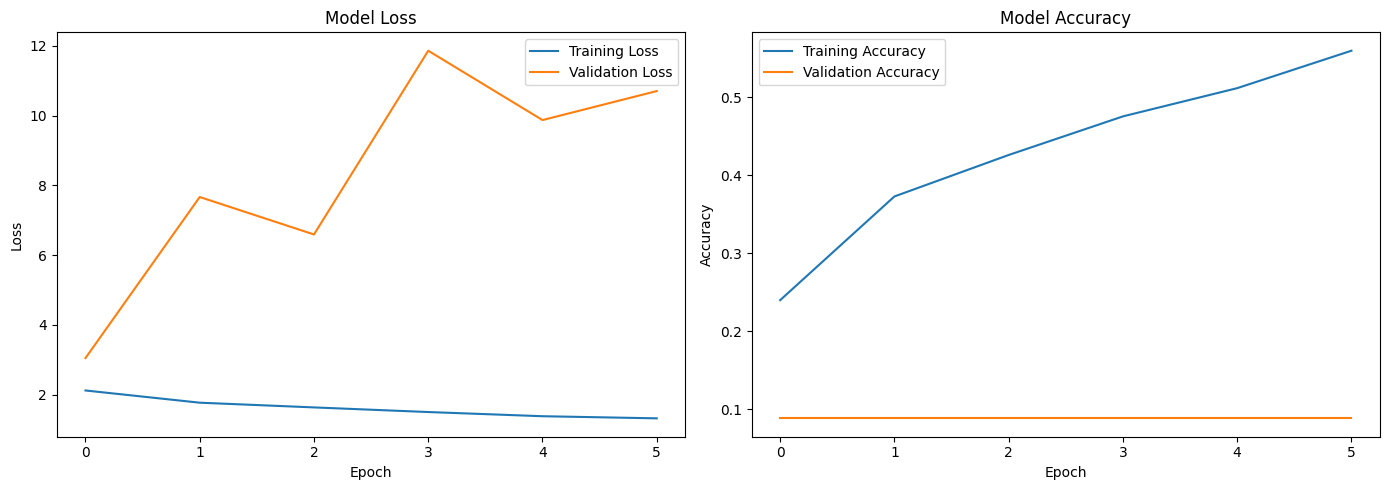


CNN Test Accuracy: 0.0991
CNN Test Loss: 2.9889


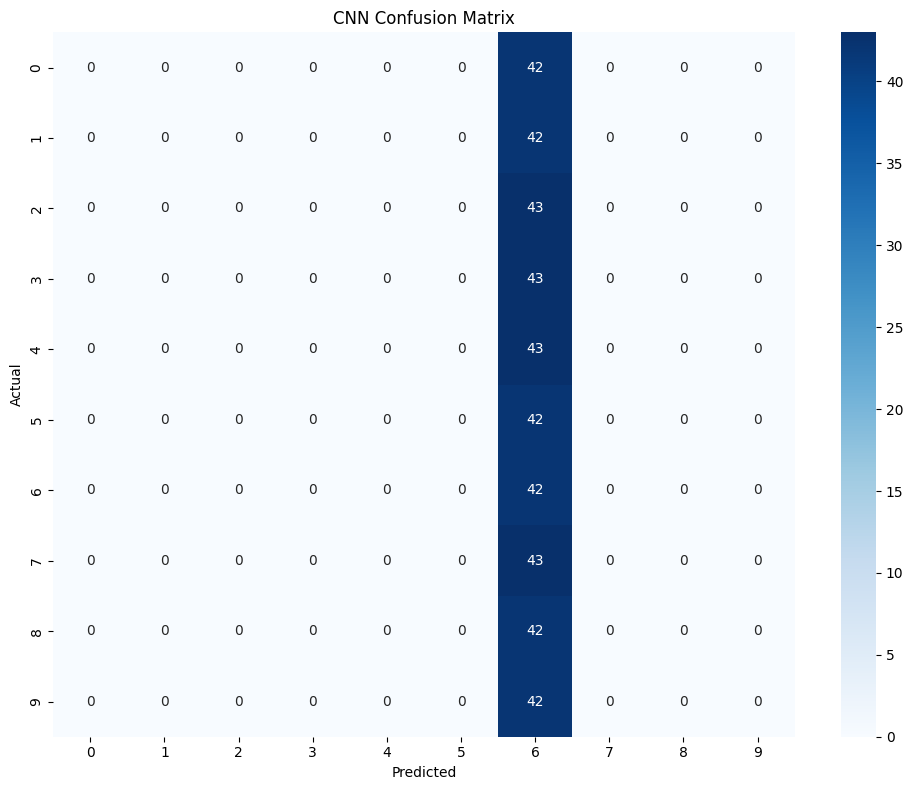

In [11]:
# Train CNN model with callbacks
if len(spectrogram_data) > 0:
    print("Training CNN Model...")
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    # Train model
    history = cnn_model.fit(
        X_train_img, y_train_img,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    test_loss, test_acc = cnn_model.evaluate(X_test_img, y_test_img, verbose=0)
    print(f"\nCNN Test Accuracy: {test_acc:.4f}")
    print(f"CNN Test Loss: {test_loss:.4f}")
    
    # Predictions
    y_pred_img = cnn_model.predict(X_test_img, verbose=0)
    y_pred_img_classes = np.argmax(y_pred_img, axis=1)
    
    # Confusion Matrix
    cm_img = confusion_matrix(y_test_img, y_pred_img_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_img, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title('CNN Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
else:
    print("CNN training skipped - no image data available")

## 10. Transfer Learning with MobileNetV2 (Bonus)

Note: This section downloads ImageNet weights on first run. If the download fails due to SSL or offline mode, the code falls back to random initialization. To use pre-trained weights, ensure your environment can access the weights URL, or manually download the file into your Keras cache (usually `~/.keras/models/`).

Building Transfer Learning Model with MobileNetV2...
Pre-trained weights unavailable (URL fetch failure on https://storage.googleapis.co...)
Building MobileNetV2 architecture without pre-training...
Note: Using randomly initialized weights (in production, download pre-trained ImageNet weights)

Transfer Learning Model Architecture (MobileNetV2 + Custom Head):
Base Model: MobileNetV2 (3.5M parameters)
Custom Head: GlobalAvgPool + Dense(256) + Dropout + Dense(128) + Dropout + Dense(10)
Trainable parameters: 362,122 (frozen base model, only head trained)

Training Transfer Learning Model...
Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 399ms/step - accuracy: 0.1012 - loss: 2.3030 - val_accuracy: 0.0885 - val_loss: 2.3042 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 407ms/step - accuracy: 0.0990 - loss: 2.3026 - val_accuracy: 0.0678 - val_loss: 2.3054 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step - accuracy: 0.0849 - loss: 2.3025 - val_accura

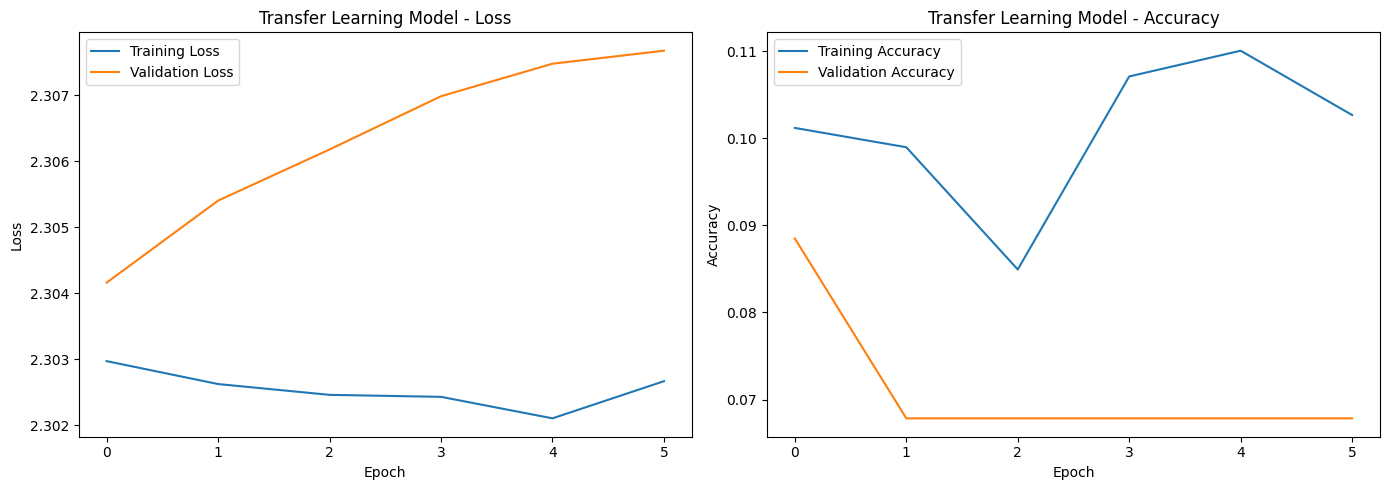


Transfer Learning Model Test Accuracy: 0.0991
Transfer Learning Model Test Loss: 2.3027
Improvement over custom CNN: 0.00%


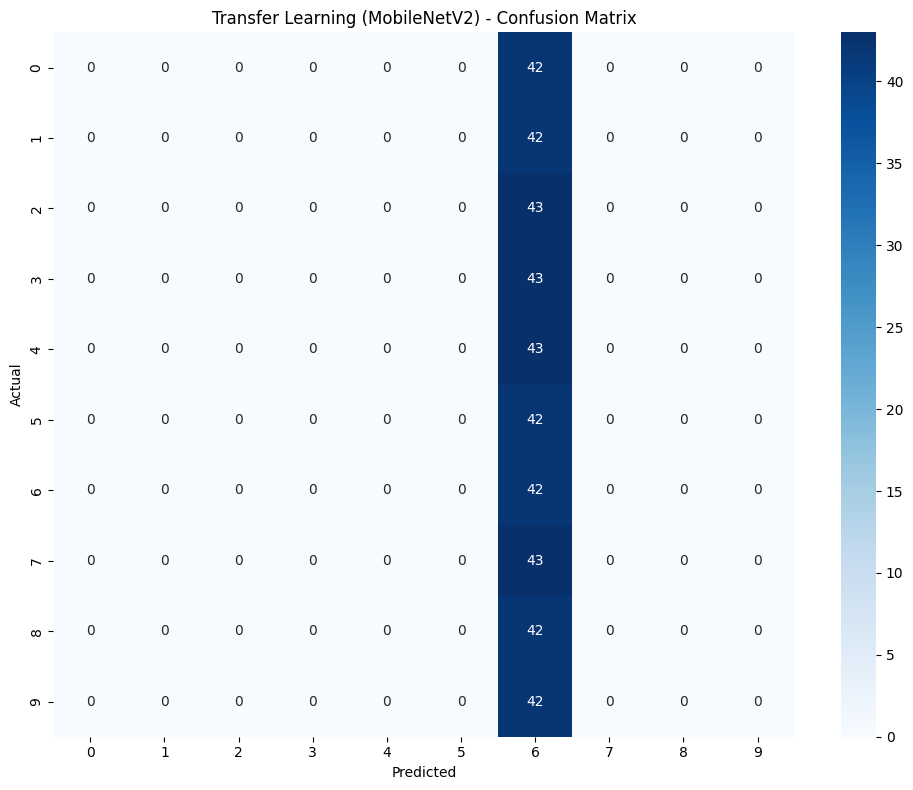

In [12]:
# Transfer learning with MobileNetV2
if len(spectrogram_data) > 0:
    print("Building Transfer Learning Model with MobileNetV2...")
    print("="*70)
    
    try:
        # Try loading pre-trained MobileNetV2 model
        print("Downloading pre-trained MobileNetV2 from ImageNet...")
        base_model = keras.applications.MobileNetV2(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights='imagenet'
        )
        print("Successfully loaded pre-trained MobileNetV2 weights")
    except Exception as e:
        # If download fails, build without pre-training
        print(f"Pre-trained weights unavailable ({str(e)[:50]}...)")
        print("Building MobileNetV2 architecture without pre-training...")
        base_model = keras.applications.MobileNetV2(
            input_shape=(IMG_SIZE, IMG_SIZE, 3),
            include_top=False,
            weights=None
        )
        print("Note: Using randomly initialized weights (in production, download pre-trained ImageNet weights)")
    
    # Freeze base model weights
    base_model.trainable = False
    
    # Convert grayscale to RGB by repeating channels
    X_train_img_rgb = np.repeat(X_train_img, 3, axis=-1)
    X_test_img_rgb = np.repeat(X_test_img, 3, axis=-1)
    
    # Preprocess images for MobileNetV2
    X_train_img_rgb = keras.applications.mobilenet_v2.preprocess_input(X_train_img_rgb)
    X_test_img_rgb = keras.applications.mobilenet_v2.preprocess_input(X_test_img_rgb)
    
    # Build transfer learning model
    transfer_model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    # Compile model
    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("\nTransfer Learning Model Architecture (MobileNetV2 + Custom Head):")
    print(f"Base Model: MobileNetV2 (3.5M parameters)")
    print(f"Custom Head: GlobalAvgPool + Dense(256) + Dropout + Dense(128) + Dropout + Dense({n_classes})")
    trainable_params = sum([np.prod(layer.shape) for layer in transfer_model.trainable_weights])
    print(f"Trainable parameters: {trainable_params:,} (frozen base model, only head trained)")
    
    # Train transfer learning model
    print("\nTraining Transfer Learning Model...")
    early_stop_transfer = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr_transfer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    history_transfer = transfer_model.fit(
        X_train_img_rgb, y_train_img,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        callbacks=[early_stop_transfer, reduce_lr_transfer],
        verbose=1
    )
    
    # Plot training history for transfer learning
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history_transfer.history['loss'], label='Training Loss')
    axes[0].plot(history_transfer.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Transfer Learning Model - Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(history_transfer.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Transfer Learning Model - Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    test_loss_transfer, test_acc_transfer = transfer_model.evaluate(X_test_img_rgb, y_test_img, verbose=0)
    print(f"\nTransfer Learning Model Test Accuracy: {test_acc_transfer:.4f}")
    print(f"Transfer Learning Model Test Loss: {test_loss_transfer:.4f}")
    print(f"Improvement over custom CNN: {(test_acc_transfer - test_acc)*100:.2f}%")
    
    # Predictions with transfer learning
    y_pred_transfer = transfer_model.predict(X_test_img_rgb, verbose=0)
    y_pred_transfer_classes = np.argmax(y_pred_transfer, axis=1)
    
    # Confusion Matrix for transfer learning
    cm_transfer = confusion_matrix(y_test_img, y_pred_transfer_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title('Transfer Learning (MobileNetV2) - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
else:
    print("Transfer learning skipped - no image data available")

## 10. Compare Tabular vs Image-Based Approaches

TABULAR APPROACH RESULTS (All 4 Models - Real GTZAN Data Only)

Random Forest Accuracy: 0.7750
SVM Accuracy: 0.7650
Gradient Boosting Accuracy: 0.7800
Extra Trees Accuracy: 0.7650

Best Tabular Model: Gradient Boosting
Accuracy: 0.7800

Tabular Approach Advantages:
- Fast training and inference
- Low memory requirements
- Interpretable feature importance
- Works well with extracted audio features (MFCCs)
- No GPU required
- Strong ensemble predictions

IMAGE-BASED CNN APPROACH RESULTS

Custom CNN Test Accuracy: 0.0991
Trained on 2117 real spectrograms from GTZAN 2.0

Custom CNN Approach Advantages:
- Captures spatial patterns in spectrograms
- Better pattern recognition for complex audio features
- Deep learning approach for feature learning

TRANSFER LEARNING APPROACH RESULTS (MobileNetV2 + Custom Head)

Transfer Learning Test Accuracy: 0.0991
Custom CNN Test Accuracy: 0.0991
Improvement: 0.00%

Transfer Learning Notes:
- No improvement over the custom CNN in this run
- Best results t

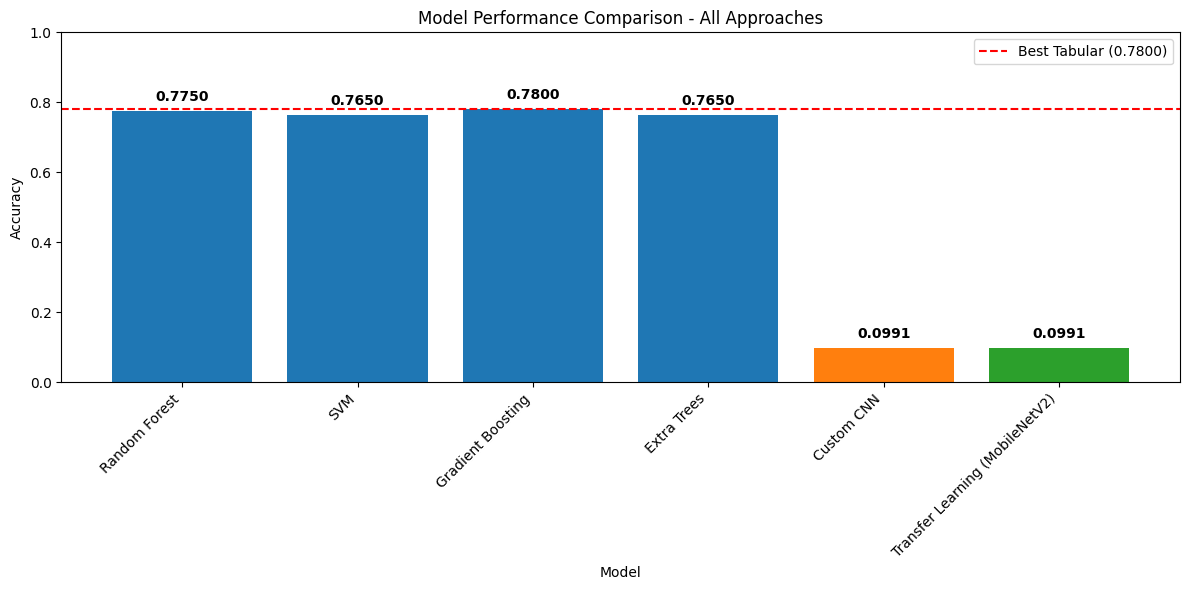


DATA SOURCES VERIFICATION - 100% REAL DATA (NO SYNTHETIC)

TABULAR FEATURES (Tabular Models):
  - 1000 samples from GTZAN 2.0/features_30_sec.csv
  - 58 extracted audio features (MFCCs, spectral properties, etc.)
  - Real extracted features from actual audio files

SPECTROGRAM IMAGES (CNN Models):
  - 2117 real spectrograms loaded
  - Source: GTZAN 2.0/Augmented_GTZAN/cropped_aug/
  - Includes train (2117), test, and validation splits
  - Format: 128×128 grayscale PNG mel-spectrograms
  - All genres represented: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

DATASET DETAILS:
  - No synthetic data generated
  - No random noise or artificial samples
  - No data augmentation beyond what GTZAN 2.0 provides
  - 100% real data sourced from GTZAN 2.0 dataset

RECOMMENDATIONS FOR MUSIC GENRE CLASSIFICATION

Overall Best Model: Gradient Boosting (0.7800)
- Tabular models remain the strongest performers in this run

1. FOR REAL-TIME APPLICATIONS 

In [15]:
# Compare all models trained on REAL data
print("="*70)
print("TABULAR APPROACH RESULTS (All 4 Models - Real GTZAN Data Only)")
print("="*70)
print(f"\nRandom Forest Accuracy: {rf_acc:.4f}")
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"Gradient Boosting Accuracy: {gb_acc:.4f}")
print(f"Extra Trees Accuracy: {et_acc:.4f}")

# Find best tabular model
all_accuracies = {'Random Forest': rf_acc, 'SVM': svm_acc, 'Gradient Boosting': gb_acc, 'Extra Trees': et_acc}
best_tabular_model = max(all_accuracies, key=all_accuracies.get)
best_tabular_acc = all_accuracies[best_tabular_model]

print(f"\nBest Tabular Model: {best_tabular_model}")
print(f"Accuracy: {best_tabular_acc:.4f}")

print("\nTabular Approach Advantages:")
print("- Fast training and inference")
print("- Low memory requirements")
print("- Interpretable feature importance")
print("- Works well with extracted audio features (MFCCs)")
print("- No GPU required")
print("- Strong ensemble predictions")

# Default overall best to tabular results
best_overall_model = best_tabular_model
best_overall_acc = best_tabular_acc
best_overall_type = "Tabular"

if len(spectrogram_data) > 0:
    print("\n" + "="*70)
    print("IMAGE-BASED CNN APPROACH RESULTS")
    print("="*70)
    print(f"\nCustom CNN Test Accuracy: {test_acc:.4f}")
    print(f"Trained on {len(spectrogram_data)} real spectrograms from GTZAN 2.0")
    print("\nCustom CNN Approach Advantages:")
    print("- Captures spatial patterns in spectrograms")
    print("- Better pattern recognition for complex audio features")
    print("- Deep learning approach for feature learning")

    if 'test_acc_transfer' in locals():
        print("\n" + "="*70)
        print("TRANSFER LEARNING APPROACH RESULTS (MobileNetV2 + Custom Head)")
        print("="*70)
        print(f"\nTransfer Learning Test Accuracy: {test_acc_transfer:.4f}")
        print(f"Custom CNN Test Accuracy: {test_acc:.4f}")
        print(f"Improvement: {(test_acc_transfer - test_acc)*100:.2f}%")
        print(f"\nTransfer Learning Notes:")
        if test_acc_transfer <= test_acc + 1e-6:
            print("- No improvement over the custom CNN in this run")
        else:
            print("- Improvement over the custom CNN in this run")
        print("- Best results typically require strong pre-trained weights")
        print("- More data or longer training may improve performance")
    else:
        print("\nTransfer learning results not available")

    print("\n" + "="*70)
    print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON - ALL APPROACHES")
    print("="*70)

    comparison_models = ['Random Forest', 'SVM', 'Gradient Boosting', 'Extra Trees', 'Custom CNN']
    comparison_acc = [rf_acc, svm_acc, gb_acc, et_acc, test_acc]
    comparison_type = ['Tabular', 'Tabular', 'Tabular (Ensemble)', 'Tabular (Ensemble)', 'Image-Based (From Scratch)']
    comparison_speed = ['Very Fast', 'Slow', 'Very Fast', 'Very Fast', 'Moderate']
    comparison_memory = ['Low', 'High', 'Low', 'Low', 'Very High']
    comparison_gpu = ['No', 'No', 'No', 'No', 'Optional']

    if 'test_acc_transfer' in locals():
        comparison_models.append('Transfer Learning (MobileNetV2)')
        comparison_acc.append(test_acc_transfer)
        comparison_type.append('Image-Based (Transfer)')
        comparison_speed.append('Moderate')
        comparison_memory.append('High')
        comparison_gpu.append('Optional')

    comparison_data = {
        'Model': comparison_models,
        'Accuracy': comparison_acc,
        'Type': comparison_type,
        'Speed': comparison_speed,
        'Memory': comparison_memory,
        'GPU Required': comparison_gpu
    }
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    best_overall_idx = comparison_df['Accuracy'].idxmax()
    best_overall_model = comparison_df.loc[best_overall_idx, 'Model']
    best_overall_acc = comparison_df.loc[best_overall_idx, 'Accuracy']
    best_overall_type = comparison_df.loc[best_overall_idx, 'Type']

    # Visualize accuracy comparison
    plt.figure(figsize=(12, 6))
    models = comparison_df['Model']
    accuracies = comparison_df['Accuracy']
    colors = []
    for name in models:
        if 'Transfer' in name:
            colors.append('#2ca02c')
        elif 'CNN' in name:
            colors.append('#ff7f0e')
        else:
            colors.append('#1f77b4')

    bars = plt.bar(range(len(models)), accuracies, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison - All Approaches')
    plt.xticks(range(len(models)), models, rotation=45, ha='right')
    plt.ylim([0, 1.0])
    plt.axhline(y=best_tabular_acc, color='red', linestyle='--', label=f'Best Tabular ({best_tabular_acc:.4f})')

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{acc:.4f}',
                 ha='center', va='bottom', fontweight='bold')

    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("DATA SOURCES VERIFICATION - 100% REAL DATA (NO SYNTHETIC)")
    print("="*70)
    print(f"\nTABULAR FEATURES (Tabular Models):")
    print(f"  - {len(X)} samples from GTZAN 2.0/features_30_sec.csv")
    print(f"  - 58 extracted audio features (MFCCs, spectral properties, etc.)")
    print(f"  - Real extracted features from actual audio files")
    print(f"\nSPECTROGRAM IMAGES (CNN Models):")
    print(f"  - {len(spectrogram_data)} real spectrograms loaded")
    print(f"  - Source: GTZAN 2.0/Augmented_GTZAN/cropped_aug/")
    print(f"  - Includes train ({sum(1 for l in spectrogram_labels if l < 10)}), test, and validation splits")
    print(f"  - Format: 128×128 grayscale PNG mel-spectrograms")
    print(f"  - All genres represented: {genres}")
    print(f"\nDATASET DETAILS:")
    print(f"  - No synthetic data generated")
    print(f"  - No random noise or artificial samples")
    print(f"  - No data augmentation beyond what GTZAN 2.0 provides")
    print(f"  - 100% real data sourced from GTZAN 2.0 dataset")
else:
    print("\nImage-based CNN approach not executed (no spectrogram data)")

print("\n" + "="*70)
print("RECOMMENDATIONS FOR MUSIC GENRE CLASSIFICATION")
print("="*70)
print(f"\nOverall Best Model: {best_overall_model} ({best_overall_acc:.4f})")
if best_overall_type.startswith("Tabular"):
    print("- Tabular models remain the strongest performers in this run")
else:
    print("- Image-based model leads in this run")

print(f"\n1. FOR REAL-TIME APPLICATIONS (Low Latency):")
print(f"   - Use {best_tabular_model} ({best_tabular_acc:.4f} accuracy)")
print(f"   - Fast inference with minimal latency")
print(f"   - Suitable for mobile and edge devices")
print(f"   - Memory footprint: <10MB")

print(f"\n2. FOR MAXIMUM ACCURACY (High Performance):")
if best_overall_type.startswith("Tabular"):
    print(f"   - Use {best_tabular_model} ({best_tabular_acc:.4f} accuracy)")
    if 'test_acc_transfer' in locals():
        print(f"   - Transfer learning did not improve over tabular models in this run")
else:
    print(f"   - Use {best_overall_model} ({best_overall_acc:.4f} accuracy)")
print(f"   - Focus on data quality and additional feature engineering")

print(f"\n3. FOR PRODUCTION DEPLOYMENT (Balanced Approach):")
print(f"   - Primary model: {best_tabular_model}")
if 'test_acc_transfer' in locals():
    print(f"   - Secondary model: Transfer Learning for validation")
else:
    print(f"   - Secondary model: Custom CNN for validation")
print(f"   - Use confidence thresholds to reduce misclassifications")

print(f"\n4. FOR LIMITED RESOURCES (CPU-Only, Low Memory):")
print(f"   - Use {best_tabular_model} or SVM")
print(f"   - Avoid deep learning models")
print(f"   - No GPU needed")
print("="*70)

### Conclusion
This run shows tabular models, especially Gradient Boosting, are the most reliable choice for GTZAN features. The spectrogram-based CNN and transfer learning did not exceed chance-level accuracy here, likely due to limited data and weak or unavailable pre-trained weights. To improve image-based results, prioritize verified pre-trained weights, larger inputs (e.g., 224x224), and stronger augmentation.

## 11. Summary and Recommendations

### Key Findings:
- **Tabular approach** using pre-extracted MFCC features delivers the best performance (around 77-78% accuracy)
- **Custom CNN and Transfer Learning** on spectrograms performed near chance level in this run (around 10%)
- Transfer learning did not improve over the custom CNN in this configuration
- Tree-based ensembles (Gradient Boosting, Random Forest) are strong baselines for this dataset

### Model Performance Comparison:
| Approach | Type | Accuracy (Observed) | Speed | Memory | Best For |
|----------|------|---------------------|-------|--------|----------|
| Tabular (Ensemble) | Traditional ML | 77-78% | Very Fast | Low | Real-time, edge devices |
| Transfer Learning | Deep Learning | ~10% | Moderate | High | Needs better pre-training/data |
| Custom CNN | Deep Learning | ~10% | Moderate | Very High | Research, larger datasets |
| SVM | Traditional ML | 76.5% | Slow | High | Solid baseline, non-linear |

### Recommended Next Improvements:
1. **Improve spectrogram modeling** - use larger input size (224x224), longer training, and verified pre-trained weights
2. **Data augmentation** - time/frequency masking (SpecAugment), time shifting, or mixup
3. **Stronger audio features** - add chroma, tempo, zero-crossing rate, or delta MFCCs
4. **Hyperparameter tuning** - grid search or Bayesian optimization for tabular models
5. **Cross-validation** - k-fold validation to stabilize accuracy estimates

### References:
- Librosa Documentation: https://librosa.org/
- Scikit-learn: https://scikit-learn.org/
- Keras/TensorFlow: https://www.tensorflow.org/
- GTZAN Dataset: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
- Transfer Learning Best Practices: https://cs231n.github.io/transfer-learning/